# Baseline Model

The goal of this notebook is to develop a scrappy baseline model which we can improve on later if we decide to implement an LSTM or otherwise. But beforehand, we need to process the data and determine what input features to use for the ANN.

## Pre-processing
1. Construct the feature/target set. 
2. Scale the data
3. Split train/test

In [130]:
import pandas as pd
import sys
import os
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
sys.path.insert(0, os.path.abspath('../')) 

from lib.common import constants as k
from lib.eirgrid import data as eirgrid_data
from lib.common.marginal_emissions import compute_mef
from lib.common.data_window import DataWindow

# Eirgrid system
eirgrid = eirgrid_data.system()
eirgrid = compute_mef(eirgrid).dropna()

There are some instances where the MEF is infinite.
This is because $\Delta PG_{i,t+1} = 0$ meaning there was no change in generation

The simplest thing to do is backfillt this with the MEF of the previous time step. 
The assumption being if there was no change in generation, the MEF should remain the same.

In [2]:
print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())
eirgrid = eirgrid.replace([np.inf, -np.inf], np.nan)
eirgrid = eirgrid.ffill()
print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())

There are 0 inf MEF values
There are 0 inf MEF values


In [3]:
eirgrid.corr(numeric_only=True)['MarginalEmissions']

SysFrequency         0.003779
Co2Emissions         0.020952
Co2Intensity         0.024599
SystemDemand         0.005024
GenExp              -0.004069
InterNet             0.004067
WindActual          -0.025451
MarginalEmissions    1.000000
Name: MarginalEmissions, dtype: float64

Linear correlation methods are unable to capture the relationship of the input features given the lack of normalality and non-linearity. It appears that the features are uncorrelated as most of the $r$ values are near zero.

A way to overcome this is through the application of Grey Relational Analysis (GRA) which can describe the relationship between these input features more aptly.

## Feature Selection
Use a combination of Grey relational analysis and PCA to figure out which features are most important. This requires that the data is scaled and the timestamps are properly encoded.

- To encode time stamps create two features to represent the cosine and sine of the time.
- Use a `MinMaxScaler` to scale the data.

This method was employed by researchers building an LSTM ANN to forecast $CO_2$ emissions in China [1]
- Domain knowledge and literature review was used to determine a list of 16 candidate features
- The key influencing factors are obtained using Grey Relational analysis
- Principal component analysis is performed on these factors to obtain the main information affecting carbon emissions & simplify input variables

---

[1] Y. Huang, L. Shen, and H. Liu, ‘Grey relational analysis, principal component analysis and forecasting of carbon emissions based on long short-term memory in China’, Journal of Cleaner Production, vol. 209, pp. 415–423, Feb. 2019, doi: 10.1016/j.jclepro.2018.10.128.

In [172]:
def feature_engineer(frame: pd.DataFrame, n_lag=0, target_column='MarginalEmissions', datetime_column='EffectiveTime') -> pd.DataFrame:
    df = frame.copy()

    # Apply a sine/cosine transformation to the timestamp to preserve the cyclical nature of the day
    # In a way that can be interpreted by the ML
    timestamp_s = df['EffectiveTime'].map(datetime.datetime.timestamp)
    day_s = 24 * 60 * 60
    features = df.drop(columns=['EffectiveTime'])

    feature_columns = features.columns
    # Lag input columns
    for lag in range(n_lag):
        for column in feature_columns:
            if column == target_column:
                continue
            features[f'{column}_lag_{lag+1}'] = features[column].shift(-1 * lag)
    
    features['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day_s))).values
    features['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day_s))).values

    # Remove the undefined features
    features = features.dropna()

    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(features)
    features[features.columns] = scaler.transform(features[features.columns])
    target = features[target_column]
    features = features.drop(columns=target_column)
    return (target, features)

target, features = feature_engineer(eirgrid)
display(features)

,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,day_sin,day_cos
56,0.511628,0.009233,0.075472,0.468589,0.572204,0.387210,0.822739,0.804381,0.103323
57,0.534884,0.014915,0.086792,0.450034,0.555917,0.399295,0.801195,0.829673,0.124080
58,0.604651,0.013139,0.090566,0.431701,0.554651,0.361531,0.805887,0.853553,0.146447
59,0.581395,0.006037,0.086792,0.412028,0.551393,0.118832,0.806741,0.875920,0.170327
60,0.441860,0.011364,0.100000,0.391907,0.522439,0.360524,0.761519,0.896677,0.195619
...,...,...,...,...,...,...,...,...,...
122476,0.697674,0.303977,0.581132,0.158059,0.254434,0.446123,0.065060,0.500000,1.000000
122477,0.767442,0.337358,0.620755,0.168791,0.260043,0.455186,0.061860,0.467298,0.998929
122478,0.720930,0.372159,0.635849,0.186452,0.288455,0.506546,0.063567,0.434737,0.995722
122479,0.604651,0.389560,0.630189,0.203666,0.313246,0.388218,0.064420,0.402455,0.990393


### Grey Relational Analysis

We're dealing with a multivariate time series (more than one input). This makes it hard to determine the relationship between our input features and targets. 

As a part of the network design we want to use as little input features as possible while still capturing the underlying relationships in the data. We also want input features that are easy to derive to make predictions easier. 

Greys Relational Analysis is a method to understand this further.

> GRA is employed to search for Grey Relational Grade (GRG) which can be used to describe the relationships between the data attributes and to determine the important factors that significantly influence some defined objectives. [2]

#### Methodology

__Preprocessing__

- The nescessary preprocessing has been done (scaling, normalising)
- The original data series $X$ is split into a reference series $x_0$ and comparative series $x_i$. In this example, $x_0$ is the target feature (.i.e. MEF) and $x_i$ represent the input factors

__Grey Relational Coefficent__

$$
\zeta_i(k) = \frac{\Delta \text{min} + \zeta \Delta \text{max}}{\Delta_{0,j}(k) + \zeta \Delta\text{max}}
$$

---

[2] R. Sallehuddin, S. M. Hj. Shamsuddin, and S. Z. M. Hashim, ‘Application of Grey Relational Analysis for Multivariate Time Series’, in 2008 Eighth International Conference on Intelligent Systems Design and Applications, Nov. 2008, pp. 432–437. doi: 10.1109/ISDA.2008.181.


In [5]:
def grey_relational_grade(features: pd.DataFrame, target: pd.Series, zeta=0.5, norm=False) -> pd.DataFrame:
    """
    Returns the grey relational grade for a feature set and target data frame.
    Data should be scaled before processing.
    """
    # Convert the DataFrame and Series to numpy arrays
    feature_data = features.values
    target_data  = target.values.reshape(-1, 1)  # Reshape target to be a 2D array for concatenation
    
    # Combine the target and features into one array with the target as the first column
    data = np.concatenate([target_data, feature_data], axis=1)
    
    # Normalize the data using MinMaxScaler
    if norm:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    
    # Calculate the absolute differences
    abs_diff = np.abs(data - data[:, [0]])
    
    # Find the minimum and maximum of the absolute differences
    min_diff = np.nanmin(abs_diff)
    max_diff = np.nanmax(abs_diff)
    
    # Calculation of the grey relational coefficient matrix
    grc = (min_diff + (zeta * max_diff)) / (abs_diff + (zeta * max_diff))
    
    # Since the first column is the target, we ignore it in the result
    grc_target = grc[:, 1:]

    # Return as data frame
    return pd.DataFrame(grc_target, columns=features.columns)

def grg_interpret(grg: pd.DataFrame, features: pd.DataFrame, target: pd.Series):
    columns = features.columns.tolist()

    plt.figure(figsize=(12,7))
    sns.heatmap(grg.mean().values.reshape(1,-1), square=True, annot=True,  cbar=False,
                    vmax=1.0, linewidths=0.1,cmap='viridis')
    plt.ylabel(target.name)
    plt.yticks([])
    plt.title("Grey's correlation matrix")
    plt.xticks(list(range(len(columns))), columns, rotation=45)
    plt.show()
    
    print("Ranked feature importance")
    display(grg.mean().sort_values(ascending=False))

def grg_relevant_features(grg: pd.DataFrame, threshold = 0.7):
    return grg.columns[grg.mean().ge(threshold)].tolist()

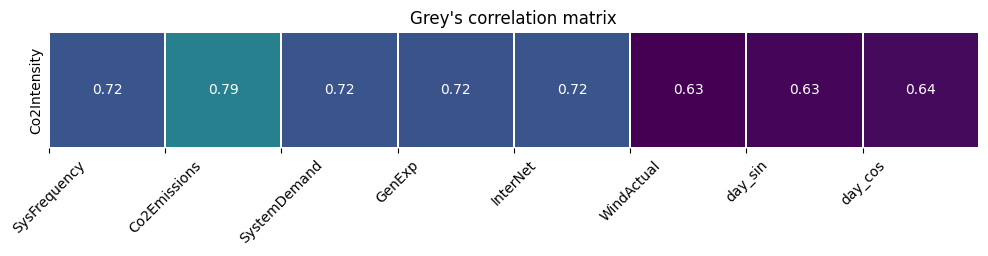

Ranked feature importance


Co2Emissions    0.787655
SysFrequency    0.723612
SystemDemand    0.722770
InterNet        0.722745
GenExp          0.722032
day_cos         0.635067
day_sin         0.631532
WindActual      0.625778
dtype: float64

['SysFrequency', 'Co2Emissions', 'SystemDemand', 'GenExp', 'InterNet']

In [169]:
co2 = features['Co2Intensity']
f2 = features.drop(columns='Co2Intensity')
grg = grey_relational_grade(f2, co2)
grg_interpret(grg, f2, co2)
grg_relevant_features(grg)

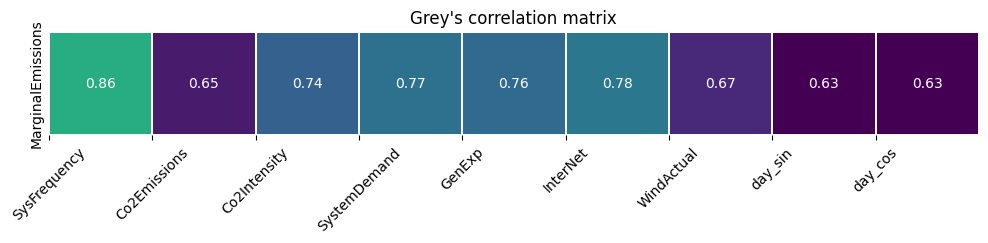

Ranked feature importance


SysFrequency    0.859813
InterNet        0.776019
SystemDemand    0.765004
GenExp          0.755301
Co2Intensity    0.742442
WindActual      0.669707
Co2Emissions    0.654884
day_cos         0.629277
day_sin         0.628644
dtype: float64

['SysFrequency', 'Co2Intensity', 'SystemDemand', 'GenExp', 'InterNet']

In [7]:
grg = grey_relational_grade(features, target)
grg_interpret(grg, features, target)
grg_relevant_features(grg)

(61220, 9)

(57716, 22)

,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,Fuel_Battery_Storage,Fuel_Biomass_Peat,Fuel_Coal,...,Fuel_Oil,Fuel_Other_Non_Renewable,Fuel_Other_Renewable,Fuel_Pumped_Storage_Hydro,Fuel_Renewable_Hydro,Fuel_Solar,Fuel_Waste,Fuel_Wind,day_sin,day_cos
0,0.682927,0.396383,0.635161,0.215150,0.317046,0.570903,0.066566,0.000000,0.262770,0.217591,...,0.061042,0.328232,0.791315,0.000206,0.187375,0.0,0.765048,0.070717,0.370590,0.982963
1,0.756098,0.379024,0.637051,0.185343,0.295021,0.485819,0.064196,0.000000,0.194073,0.144294,...,0.061491,0.327958,0.779759,0.000343,0.192389,0.0,0.764530,0.074486,0.434737,0.995722
2,0.731707,0.309584,0.582231,0.156880,0.260226,0.422794,0.065704,0.000000,0.193602,0.142063,...,0.061814,0.328232,0.764228,0.000412,0.190896,0.0,0.765020,0.075945,0.500000,1.000000
3,0.439024,0.280289,0.551985,0.136486,0.249491,0.569328,0.066997,0.000000,0.193307,0.135158,...,0.061937,0.328505,0.776301,0.000343,0.188511,0.0,0.767264,0.073740,0.565263,0.995722
4,0.487805,0.282459,0.553875,0.122143,0.250046,0.368697,0.066997,0.000000,0.193602,0.150738,...,0.061950,0.328778,0.795759,0.000343,0.189743,0.0,0.765545,0.068450,0.629410,0.982963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58459,0.609756,0.073418,0.137996,0.495294,0.533037,0.630777,0.700991,0.000000,0.164202,0.186573,...,0.177361,0.221372,0.661654,0.038216,0.609219,0.0,0.896206,0.680724,0.195619,0.896677
58460,0.317073,0.075949,0.155009,0.451815,0.529150,0.250000,0.683542,0.013935,0.164261,0.186289,...,0.119692,0.225745,0.661341,0.040961,0.608847,0.0,0.899908,0.663940,0.250000,0.933013
58461,0.853659,0.043761,0.134216,0.406544,0.489358,0.445903,0.686127,0.000000,0.159135,0.175879,...,0.005451,0.225471,0.655872,0.031835,0.594453,0.0,0.882094,0.631130,0.308658,0.961940
58462,0.829268,0.007233,0.102079,0.369341,0.418471,0.597164,0.659629,0.000054,0.122606,0.174533,...,0.000000,0.224105,0.655755,0.004185,0.603090,0.0,0.818920,0.642412,0.370590,0.982963


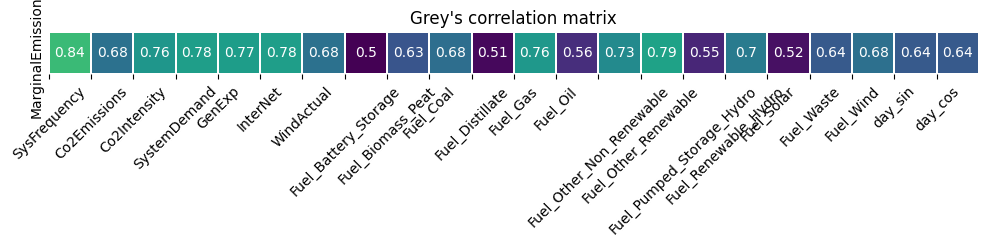

Ranked feature importance


SysFrequency                 0.837926
Fuel_Other_Renewable         0.785356
SystemDemand                 0.777216
InterNet                     0.777019
GenExp                       0.774400
Fuel_Gas                     0.764736
Co2Intensity                 0.761515
Fuel_Other_Non_Renewable     0.734765
Fuel_Renewable_Hydro         0.704294
Co2Emissions                 0.683564
WindActual                   0.682820
Fuel_Wind                    0.679740
Fuel_Coal                    0.676386
day_cos                      0.636831
day_sin                      0.636365
Fuel_Waste                   0.636206
Fuel_Biomass_Peat            0.629097
Fuel_Oil                     0.561280
Fuel_Pumped_Storage_Hydro    0.549927
Fuel_Solar                   0.516363
Fuel_Distillate              0.506322
Fuel_Battery_Storage         0.495445
dtype: float64

Updated relevant feature set


['SysFrequency',
 'Co2Intensity',
 'SystemDemand',
 'GenExp',
 'InterNet',
 'Fuel_Gas',
 'Fuel_Other_Non_Renewable',
 'Fuel_Other_Renewable',
 'Fuel_Renewable_Hydro']

Complete relevant feature set


{'Co2Intensity',
 'Fuel_Gas',
 'Fuel_Other_Non_Renewable',
 'Fuel_Other_Renewable',
 'Fuel_Renewable_Hydro',
 'GenExp',
 'InterNet',
 'SysFrequency',
 'SystemDemand'}

In [96]:
# Fuel mix
fuel_mix = pd.read_csv(k.PROCESSED_DATA_DIR / 'fuel_mix.csv', index_col=0)
fuel_mix.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
fuel_mix['EffectiveTime'] = pd.to_datetime(fuel_mix['EffectiveTime'])

# Pricing data
pricing = pd.read_csv(k.RAW_DATA_DIR / 'semo' / 'price_all_latest.csv', index_col=0)
pricing = pricing[['StartTime', 'NetImbalanceVolume', 'ImbalanceSettlementPrice']]
pricing.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
pricing['EffectiveTime'] = pd.to_datetime(pricing['EffectiveTime'])

# Reformat data frame
df = eirgrid.copy().set_index('EffectiveTime')
df = df.resample('30T').asfreq()
df = df.reset_index()
display(df.shape)

# Join with fuel mix data
df = df.merge(fuel_mix, on='EffectiveTime', how='left')
df = df.dropna()
display(df.shape)

# # Join with pricing data
# df = df.merge(pricing.drop(columns='NetImbalanceVolume'), on='EffectiveTime', how='left')
# df = df.dropna()
# display(df)

# Calculate MEF
target_updated, features_updated = feature_engineer(df)
display(features_updated)
grg_updated = grey_relational_grade(features_updated, target_updated)
grg_interpret(grg_updated, features_updated, target_updated)

print('Updated relevant feature set')
display(grg_relevant_features(grg_updated))
print('Complete relevant feature set')
relevant_features = set(grg_relevant_features(grg_updated) + grg_relevant_features(grg))
relevant_features

## Principal Component Analysis

We've identified 8 potential input features, let's try reduce the dimensionality using PCA. PCA can help us do this by creating linear combinations of the input features in a way that maintains the underlying variance in the dataset. 

We can also use this to further identify and isolate the mitigating factors to build out the baseline model

In [97]:
features_df = features_updated[list(relevant_features)]
pca_features = features_df.values
pca_target = target_updated.values
pca = PCA(n_components=0.95)
pca_components = pca.fit_transform(pca_features)
pca_variances = pca.explained_variance_ratio_
principal_df = pd.DataFrame(data=pca_components, columns=[f'PCA_{i}' for i in range(len(pca_variances))])
principal_df['target'] = pca_target
combined_variance = np.sum(pca.explained_variance_ratio_)*100
display(principal_df)
display(pca_variances)
print('Using %d/%d components %.2f%% of the variance is retained' % (len(pca_variances), len(features_df.columns), combined_variance))

# We can recover the most significant feature in each principal component
# This is given to us in the `pca.components_`
n_pcs = pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = features_df.columns
# get the most important feature names
most_important_features = [(i, initial_feature_names[most_important[i]], pca.components_[i][most_important[i]]) for i in range(n_pcs)]

# print('PCA Components')
# display(pca.components_)

print('The most important features from the PCA analysis are')
most_important_cols = list(set(map(lambda x: x[1], most_important_features)))
most_important_features, most_important_cols

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,target
0,-0.322353,0.171232,0.007584,0.068379,-0.114906,-0.089144,-0.083935,0.521205
1,-0.329605,0.161433,-0.063731,0.073216,-0.167856,-0.163248,-0.096611,0.513815
2,-0.333738,0.094826,-0.102301,0.066851,-0.196612,-0.139287,-0.114770,0.522895
3,-0.365739,0.089537,0.035168,0.068617,-0.176650,0.156986,-0.107859,0.513531
4,-0.346117,0.048534,-0.148187,0.085594,-0.233861,0.102759,-0.136506,0.513010
...,...,...,...,...,...,...,...,...
57711,0.355999,-0.265467,0.239434,-0.054230,0.076946,-0.012850,-0.049495,0.515625
57712,0.371842,-0.363501,-0.110816,-0.011312,-0.066523,0.260871,-0.032472,0.519410
57713,0.320391,-0.370068,0.090823,-0.018664,0.016877,-0.264530,-0.073446,0.514071
57714,0.270416,-0.379142,0.254609,-0.011081,0.017884,-0.236332,-0.092420,0.514070


array([0.30109703, 0.23090512, 0.15480002, 0.10758557, 0.09547028,
       0.0372612 , 0.03274718])

Using 7/9 components 95.99% of the variance is retained
The most important features from the PCA analysis are


([(0, 'Fuel_Renewable_Hydro', 0.7344976897796635),
  (1, 'Fuel_Gas', 0.6924800307242817),
  (2, 'InterNet', 0.9055085605637128),
  (3, 'Fuel_Other_Non_Renewable', 0.6596135057290716),
  (4, 'Fuel_Other_Non_Renewable', 0.5067872142666056),
  (5, 'SysFrequency', -0.9843025675769826),
  (6, 'Fuel_Other_Renewable', -0.8043536002327313)],
 ['Fuel_Gas',
  'Fuel_Other_Renewable',
  'InterNet',
  'SysFrequency',
  'Fuel_Renewable_Hydro',
  'Fuel_Other_Non_Renewable'])

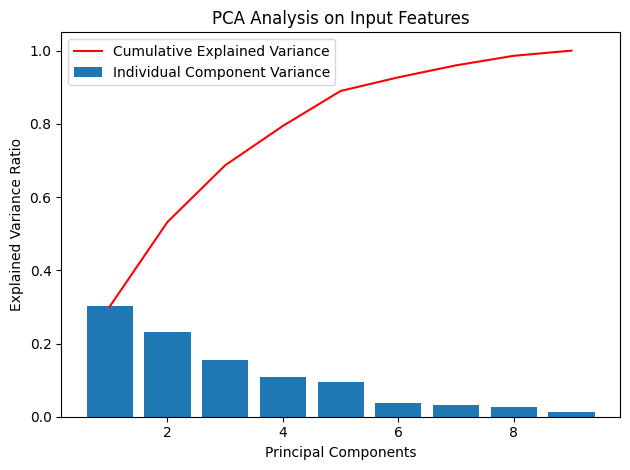

In [98]:
pca = PCA(n_components=0.9999)
pca_components = pca.fit_transform(pca_features)
pca_variances = pca.explained_variance_ratio_
plt.figure()
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(components, pca.explained_variance_ratio_, align='center', label='Individual Component Variance')
plt.plot(components, np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance', color='red')
plt.title('PCA Analysis on Input Features')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Training Data

Given the input features have been identified we can export our training data for later use. 


#### Feature Selection
We're going to use 5 input features to start with
1. ImbalanceSettlmentPrice $p_t$
2. InterNet $k_t$
3. SysFrequency $q_t$
4. SystemDemand $d_t$
5. WindActual $\omega_t$
6. Fuel_Mixed $m_t$

Based on the combined Gray's analysis and dimensionality reduction using PCA. Interestingly enough, it seems that the time of the day (`day_cos` `day_sin` information) is not relevant to the prediction. Probabably because the underlying system information contributes more to the MEF than the time of day.


In [230]:
scaler = RobustScaler()
target_scaler = RobustScaler()
target = ['Co2Intensity']
feature_cols = ['InterNet', 'SystemDemand', 'GenExp', 'SysFrequency', 'WindActual', 'Fuel_Gas']
training_data = df.copy()
training_data = training_data.dropna()
training_data = training_data.reindex(columns=feature_cols + target)
training_data[feature_cols] = scaler.fit_transform(training_data[feature_cols].values)
training_data[target] = target_scaler.fit_transform(training_data[target].values)
training_data.to_csv(k.PROCESSED_DATA_DIR / 'features_target.csv')
training_data

,InterNet,SystemDemand,GenExp,SysFrequency,WindActual,Fuel_Gas,Co2Intensity
0,0.289803,-0.761240,-0.350703,0.666667,-0.536420,0.453013,0.837838
1,0.000000,-0.864341,-0.449132,1.166667,-0.542631,0.565566,0.844595
2,-0.214669,-0.962791,-0.604632,1.000000,-0.538679,0.547568,0.648649
3,0.284436,-1.033333,-0.652605,-1.000000,-0.535291,0.508266,0.540541
4,-0.398927,-1.082946,-0.650124,-0.666667,-0.535291,0.555818,0.547297
...,...,...,...,...,...,...,...
58459,0.493739,0.207752,0.614557,0.166667,1.126482,-0.930233,-0.939189
58460,-0.803220,0.057364,0.597188,-1.833333,1.080745,-0.846567,-0.878378
58461,-0.135957,-0.099225,0.419355,1.833333,1.087521,-1.046641,-0.952703
58462,0.379249,-0.227907,0.102564,1.666667,1.018069,-1.071912,-1.067568


## Baseline Model MLP

In [231]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense
import keras.optimizers as optimisers 
import keras

# Create feature columns
X = training_data.drop(columns=target)
Y = training_data[target]

# Train test split with 20% test size
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Setup validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print(f"Training set: {Y_train.size}; val: {Y_val.size}; test: {len(Y_test)}")

Training set: 34629; val: 11543; test: 11544


In [241]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], ), name='features'))
model.add(Dense(80, activation="relu"))
model.add(Dense(35, activation="relu"))
model.add(Dense(len(target), activation="linear"))
model.compile(loss='mae', optimizer=keras.optimizers.Adam())
model.summary()
print(f'Number of neurons: {model.count_params()} vs {Y_train.size - (model.count_params()*10)}')

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_165 (Dense)           (None, 80)                560       
                                                                 
 dense_166 (Dense)           (None, 35)                2835      
                                                                 
 dense_167 (Dense)           (None, 1)                 36        
                                                                 
Total params: 3431 (13.40 KB)
Trainable params: 3431 (13.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Number of neurons: 3431 vs 319


In [242]:
history = model.fit(X_train, Y_train,
          epochs=8*X_train.shape[1],
          batch_size=16,
          validation_data=(X_val, Y_val),
          callbacks=[keras.callbacks.EarlyStopping()])

Epoch 1/48
2165/2165 [==============================] - 1s 583us/step - loss: 0.2224 - val_loss: 0.2044
Epoch 2/48
2165/2165 [==============================] - 1s 523us/step - loss: 0.2013 - val_loss: 0.1987
Epoch 3/48
2165/2165 [==============================] - 1s 502us/step - loss: 0.1986 - val_loss: 0.2013


In [243]:
loss = model.evaluate(X_test, Y_test)
print('MAE %.2f' % loss)

361/361 [==============================] - 0s 366us/step - loss: 0.2004
MAE 0.20


In [244]:
Y_predict = model.predict(X_test)
Y_predict = target_scaler.inverse_transform(Y_predict)
Y_actual = target_scaler.inverse_transform(Y_test)
res = pd.DataFrame({
  'Predicted': Y_predict.reshape(-1),
  'Actual': Y_actual.reshape(-1)
})
res['Diff'] = res['Predicted'] - res['Actual']
res

361/361 [==============================] - 0s 417us/step


,Predicted,Actual,Diff
0,253.160370,222.0,31.160370
1,396.866547,356.0,40.866547
2,256.595917,222.0,34.595917
3,447.125000,398.0,49.125000
4,245.248291,265.0,-19.751709
...,...,...,...
11539,360.395782,345.0,15.395782
11540,376.616058,373.0,3.616058
11541,402.048523,396.0,6.048523
11542,393.749664,492.0,-98.250336
